In [ ]:
!pip install transformers torch tqdm scikit-learn pandas


In [ ]:
# =====================================================
# FAKE NEWS CLASSIFICATION – WELFake Dataset (CLEAN & PRO)
# DistilBERT + PyTorch Manual Training + FULL FIX DATA LEAK
# =====================================================

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, gc
warnings.filterwarnings("ignore")

In [ ]:

# ================== 1. CÀI ĐẶT THIẾT BỊ & SEED ==================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


Using device: cuda


In [ ]:


# ================== 2. TẢI & LÀM SẠCH DỮ LIỆU ==================
print("Đang tải dữ liệu...")
df = pd.read_csv("/content/WELFake_Dataset.csv")

print(f"Kích thước ban đầu: {df.shape}")
print(f"Số giá trị NaN:\n{df.isnull().sum()}")

# ---  LOẠI TRÙNG THEO TITLE  ---
print("\n=== LOẠI BỎ DỮ LIỆU TRÙNG (BẮT BUỘC VỚI WELFake) ===")
initial_len = len(df)

#  loại trùng theo title (vì >95% bài trùng là do cùng tiêu đề)
df = df.drop_duplicates(subset=['title'], keep='first')

# Xử lý NaN
df = df.fillna({"title": "", "text": ""})

final_len = len(df)
print(f"Đã loại bỏ: {initial_len - final_len:,} mẫu trùng tiêu đề")
print(f"Kích thước sau khi làm sạch: {final_len:,}")

# Ghép title + text (title rất quan trọng với fake news)
df["text"] = df["title"] + " [SEP] " + df["text"]

# Loại cột thừa
df = df[["text", "label"]].reset_index(drop=True)

# Kiểm tra phân bố nhãn
print(f"\nPhân bố nhãn sau làm sạch:\n{df['label'].value_counts()}")


Đang tải dữ liệu...
Kích thước ban đầu: (72134, 4)
Số giá trị NaN:
Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

=== LOẠI BỎ DỮ LIỆU TRÙNG (BẮT BUỘC VỚI WELFake) ===
Đã loại bỏ: 9,786 mẫu trùng tiêu đề
Kích thước sau khi làm sạch: 62,348

Phân bố nhãn sau làm sạch:
label
0    34407
1    27941
Name: count, dtype: int64


In [ ]:
# ================== 3. CHIA DỮ LIỆU (Stratified) ==================
X = df["text"].tolist()
y = df["label"].astype(int).tolist()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain size: {len(X_train):,} | Val size: {len(X_val):,}")



Train size: 49,878 | Val size: 12,470


In [ ]:


# ================== 4. TOKENIZER & DATASET ==================
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 512

class FakeNewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=MAX_LEN,
            return_tensors="pt",
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

train_dataset = FakeNewsDataset(X_train, y_train)
val_dataset = FakeNewsDataset(X_val, y_val)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# ================== 5. KHỞI TẠO MODEL & OPTIMIZER ==================
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
total_steps = len(train_loader) * 3
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=total_steps)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:


# ================== 6. HUẤN LUYỆN (với early stopping nhẹ) ==================
EPOCHS = 5
best_f1 = 0.0
patience = 2
no_improve = 0

print("\n" + "="*60)
print("BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH (DistilBERT)")
print("="*60)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]")

    for batch in loop:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # chống exploding gradient
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} | Avg Train Loss: {avg_train_loss:.4f}")

    # === Đánh giá trên val ===
    model.eval()
    y_true, y_pred = [], []
    val_loss = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

            preds = torch.argmax(outputs.logits, dim=-1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    avg_val_loss = val_loss / len(val_loader)

    print(f"Validation | Acc: {acc:.4f} | F1: {f1:.4f} | Loss: {avg_val_loss:.4f}")

    # Early stopping + save best model
    if f1 > best_f1:
        best_f1 = f1
        no_improve = 0
        torch.save(model.state_dict(), "best_distilbert_welfake_clean.pth")
        print(f"→ Đã lưu model tốt nhất (F1 = {f1:.4f})")
    else:
        no_improve += 1
        print(f"→ Không cải thiện ({no_improve}/{patience})")
        if no_improve >= patience:
            print("Early stopping!")
            break

print("\n" + "="*60)
print(f"KẾT THÚC HUẤN LUYỆN | Best F1: {best_f1:.4f}")
print("Model tốt nhất đã được lưu: best_distilbert_welfake_clean.pth")
print("="*60)




BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH (DistilBERT)


Epoch 1/5 [Train]: 100%|██████████| 3118/3118 [39:25<00:00,  1.32it/s, loss=0.000255]


Epoch 1 | Avg Train Loss: 0.0494


Epoch 1 [Val]: 100%|██████████| 780/780 [03:17<00:00,  3.94it/s]


Validation | Acc: 0.9921 | F1: 0.9921 | Loss: 0.0262
→ Đã lưu model tốt nhất (F1 = 0.9921)


Epoch 2/5 [Train]: 100%|██████████| 3118/3118 [39:17<00:00,  1.32it/s, loss=2.47e-5]


Epoch 2 | Avg Train Loss: 0.0133


Epoch 2 [Val]: 100%|██████████| 780/780 [03:18<00:00,  3.92it/s]


Validation | Acc: 0.9955 | F1: 0.9955 | Loss: 0.0203
→ Đã lưu model tốt nhất (F1 = 0.9955)


Epoch 3/5 [Train]: 100%|██████████| 3118/3118 [39:17<00:00,  1.32it/s, loss=1.05e-5]


Epoch 3 | Avg Train Loss: 0.0035


Epoch 3 [Val]: 100%|██████████| 780/780 [03:18<00:00,  3.94it/s]


Validation | Acc: 0.9951 | F1: 0.9951 | Loss: 0.0296
→ Không cải thiện (1/2)


Epoch 4/5 [Train]: 100%|██████████| 3118/3118 [39:15<00:00,  1.32it/s, loss=5.36e-6]


Epoch 4 | Avg Train Loss: 0.0011


Epoch 4 [Val]: 100%|██████████| 780/780 [03:18<00:00,  3.94it/s]

Validation | Acc: 0.9955 | F1: 0.9955 | Loss: 0.0334
→ Không cải thiện (2/2)
Early stopping!

KẾT THÚC HUẤN LUYỆN | Best F1: 0.9955
Model tốt nhất đã được lưu: best_distilbert_welfake_clean.pth


In [ ]:
# ================== 7. ĐÁNH GIÁ CUỐI CÙNG ==================
model.load_state_dict(torch.load("best_distilbert_welfake_clean.pth"))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in tqdm(val_loader, desc="Final Evaluation"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")

print("\n" + "="*50)
print("KẾT QUẢ CUỐI CÙNG (TRÊN DỮ LIỆU ĐÃ LÀM SẠCH)")
print(f"Accuracy : {acc:.4f}")
print(f"Weighted F1 : {f1:.4f}")
print(classification_report(y_true, y_pred, target_names=["Fake", "Real"], digits=4))
print("="*50)

Final Evaluation: 100%|██████████| 780/780 [03:17<00:00,  3.95it/s]


KẾT QUẢ CUỐI CÙNG (TRÊN DỮ LIỆU ĐÃ LÀM SẠCH)
Accuracy : 0.9955
Weighted F1 : 0.9955
              precision    recall  f1-score   support

        Fake     0.9971    0.9948    0.9959      6882
        Real     0.9936    0.9964    0.9950      5588

    accuracy                         0.9955     12470
   macro avg     0.9953    0.9956    0.9955     12470
weighted avg     0.9955    0.9955    0.9955     12470



<Figure size 600x600 with 0 Axes>

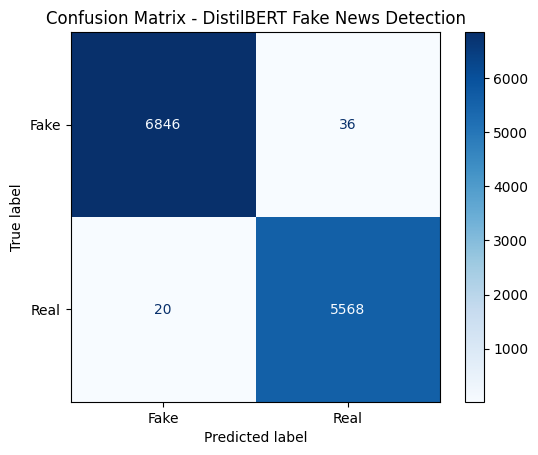

In [ ]:
# ============================================
# HIỂN THỊ MA TRẬN NHẦM LẪN
# ============================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])

# Vẽ
plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - DistilBERT Fake News Detection")
plt.show()
